# BMI 203- Implementation of Auto-Encoder + Classifier
## Sanjay Rangavajjhala

# MNIST Digit Autoencoder

In [1]:
# Imports
import os
import sys
from nn.nn import NeuralNetwork
from nn.preprocess import sample_seqs, one_hot_encode_seqs
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## load digits through sklearn

In [2]:
mnist_digits = datasets.load_digits()

## Split data into training and validation sets

In [3]:
#Split mnist data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(mnist_digits.data, mnist_digits.target, test_size=0.2, random_state=42)

## Generate an instance of my NeuralNetwork with 64x16x64 architecture

In [14]:
#Create architecture for 64x16x64 autoencoder
autoencoder_arch = [
    {"input_dim": 64, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 64, "activation": "relu"},
]
nn = NeuralNetwork(autoencoder_arch, lr=0.003, seed=42, batch_size=16, epochs=300, loss_function="mean_squared_error")

## Train autoencoder

In [15]:
train_loss, val_loss = nn.fit(X_train, X_train, X_val, X_val)

## Plot training/validation loss by epoch

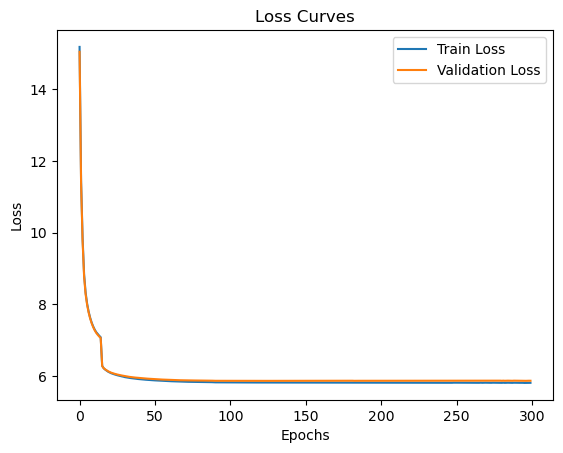

In [16]:
#Plot loss curves
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Quantify average reconstruction error over validation set

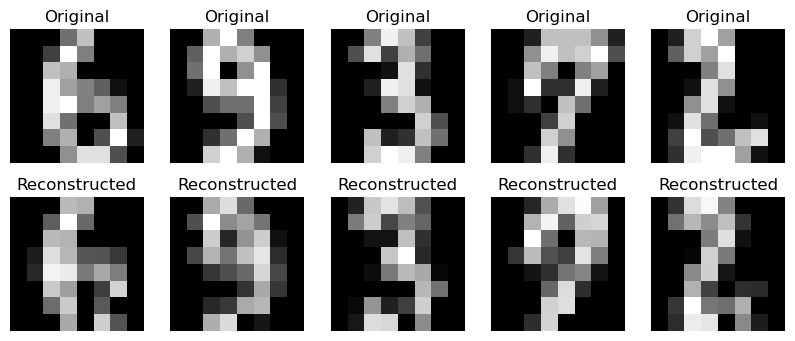

In [17]:
reconstruction = nn.predict(X_val)

#View the original and reconstructed images
n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_val[i].reshape(8, 8), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruction[i].reshape(8, 8), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

In [18]:
ave_val_error = np.mean(np.square(X_val - reconstruction))
print(f"Average Validation Error: {ave_val_error}")

Average Validation Error: 5.87020531635054


## Explain choice of hyperparameters

When choosing hyperparameters, the most important one in the quality of my model was the learning rate. I began at lr=0.01 and saw that the losses seemed to bounce heavily between ~5 and ~14, which indicated that the lr was too big. I shifted it down to 0.005 and still saw some jumpiness in both the train and validation set, so I reduced it to 1. Batch size, when varied between 8, 16, and 32, did not seem to have an effect on loss so I left it at 16. Finally, I set the number of epochs to 300 because by that point the loss curves showed that there was little to no further improvement in either the train or validation set. I use mse as my lsos because this was not a classification model, and relu as my activations seemed to show better results than binary cross entropy.

# Part 2: Classifying transcription factors